### Install and Import Packages

In [2]:
# Utils import 
import import_ipynb
from Utils import * 

# Imports 
import torch 
import numpy as np 
from PIL import Image
from evaluate import load
from datasets import load_dataset 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer

importing Jupyter notebook from Utils.ipynb


C:\Users\Sania\image-captioning\img_captioning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset creation 

#### Define Data Paths 

In [3]:
DATA_PATHS["save_model_dir"] += "blip/"
DATA_PATHS["checkpoints_dir"] += "blip/"

#### Create metadata.jsonl file 

The dataset is organized as directed on the huggingface documentation on creating an image dataset https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset
    
Captions structure :

    [{file_name: "404/404.png", "prompt": "This is a 404 page design"}]

### Define and Preprocess Datasets 

In [4]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.max_text_length=512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["prompts"], return_tensors="pt")
        
        # Padding 
        input_ids = encoding["input_ids"].tolist()[0]
        attention_mask = encoding["attention_mask"].tolist()[0]
        
        encoding["input_ids"] = torch.tensor(input_ids + [0] * (self.max_text_length - len(input_ids)))
        encoding["attention_mask"] = torch.tensor(attention_mask + [0] * (self.max_text_length - len(attention_mask))) 
        encoding.update({"labels": encoding["input_ids"]})
                                                          
        # Remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding     

In [5]:
dataset = load_dataset("imagefolder", data_dir=DATA_PATHS["image_set_path"], split="train", drop_labels=False)
train_dataset, test_dataset = dataset.train_test_split(train_size=0.8, test_size=0.2).values()

In [6]:
dataset

Dataset({
    features: ['image', 'label', 'prompts'],
    num_rows: 120
})

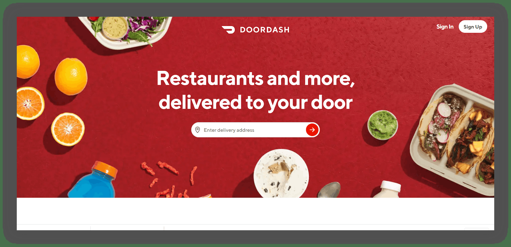

In [7]:
example = train_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", kwargs="padding")

In [9]:
train_ds = ImageCaptioningDataset(train_dataset, processor)
test_ds = ImageCaptioningDataset(test_dataset, processor)

In [10]:
item = train_ds[0]
for k,v in item.items():
    print(k,v.shape)

pixel_values torch.Size([3, 384, 384])
input_ids torch.Size([512])
attention_mask torch.Size([512])
labels torch.Size([512])


In [11]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=40)
test_dataloader = DataLoader(test_ds, shuffle=True, batch_size=2)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([40, 3, 384, 384])
input_ids torch.Size([40, 512])
attention_mask torch.Size([40, 512])
labels torch.Size([40, 512])


### Fine-tuning

In [13]:
wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = np.array(labels)
    predicted = np.array(logits[0].argmax(-1)) 
    
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [14]:
training_args = TrainingArguments(
    output_dir=DATA_PATHS["checkpoints_dir"],
    learning_rate=5e-5,
    num_train_epochs=1,
    gradient_accumulation_steps=1,
    save_total_limit=1,
    evaluation_strategy="steps",
    eval_steps=1,
    save_strategy="steps",
    save_steps=1,
    logging_steps=1,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [15]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Wer Score
1,13.107200,11.324542,1.657216
2,11.381000,9.857612,1.288660
3,9.846200,9.274989,13.175258
4,9.266100,8.963508,5.090206
5,8.985100,8.737678,11.231959
6,8.775000,8.585256,24.824742
7,8.594400,8.467668,27.548969
8,8.492000,8.369374,27.386598
9,8.379800,8.293339,27.615979
10,8.291700,8.238303,27.685567


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=12, training_loss=9.296525478363037, metrics={'train_runtime': 1898.0732, 'train_samples_per_second': 0.051, 'train_steps_per_second': 0.006, 'total_flos': 5.69686706136023e+16, 'train_loss': 9.296525478363037, 'epoch': 1.0})

### Plot loss curves 

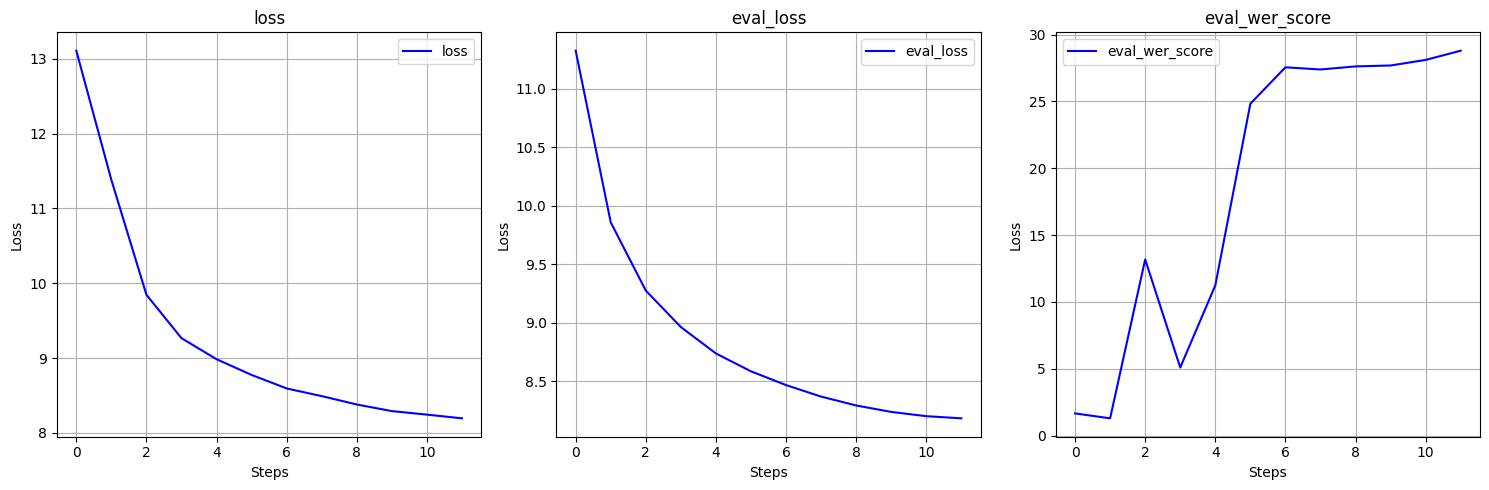

In [17]:
track_losses(trainer)

### Save model 

In [18]:
# Save the model 
trainer.save_model(DATA_PATHS["save_model_dir"])

### Inference

In [19]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", kwargs="padding")
model = BlipForConditionalGeneration.from_pretrained(DATA_PATHS["save_model_dir"])

In [20]:
inference_dict = {}
inference_files = [img for img in os.listdir(DATA_PATHS["inference_set_dir"]) if img != '.gitkeep']
for img in inference_files: 
    image = Image.open(DATA_PATHS["inference_set_dir"] + img).convert("RGB")
    
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=200, num_return_sequences=5, top_k=100, do_sample=True, temperature=0.8)
    inference_dict[img] = processor.batch_decode(generated_ids, skip_special_tokens=True)

complete_image_set/inference/404.png


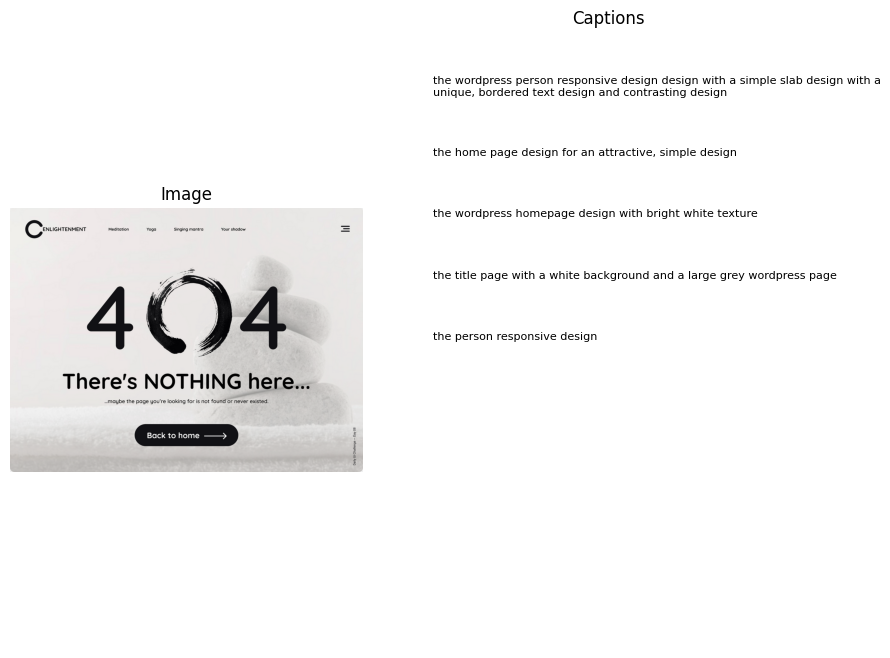

complete_image_set/inference/about_test.jpg


C:\Users\Sania\image-captioning\img_captioning\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4523 (\N{HANGUL JONGSEONG NIEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


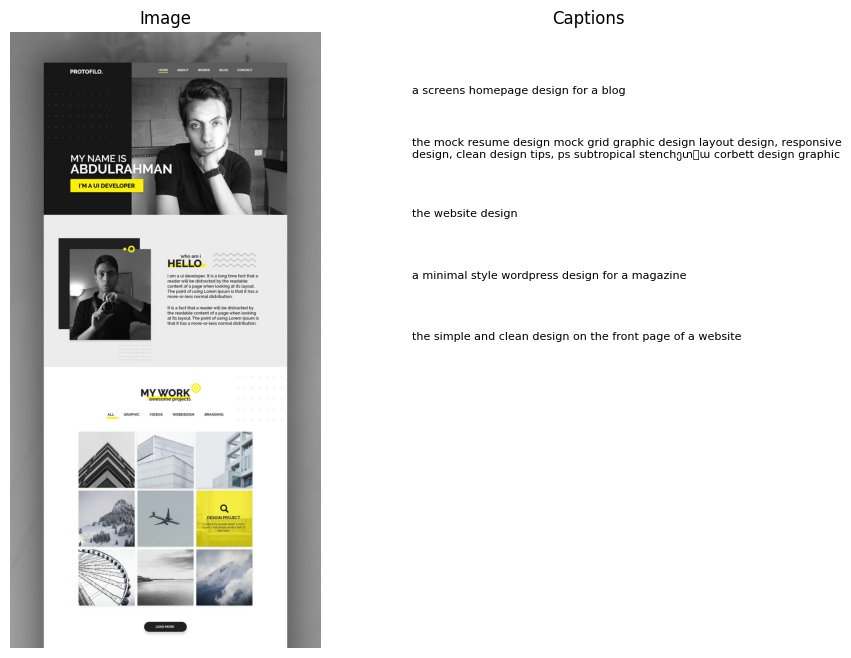

complete_image_set/inference/about_us_test.png


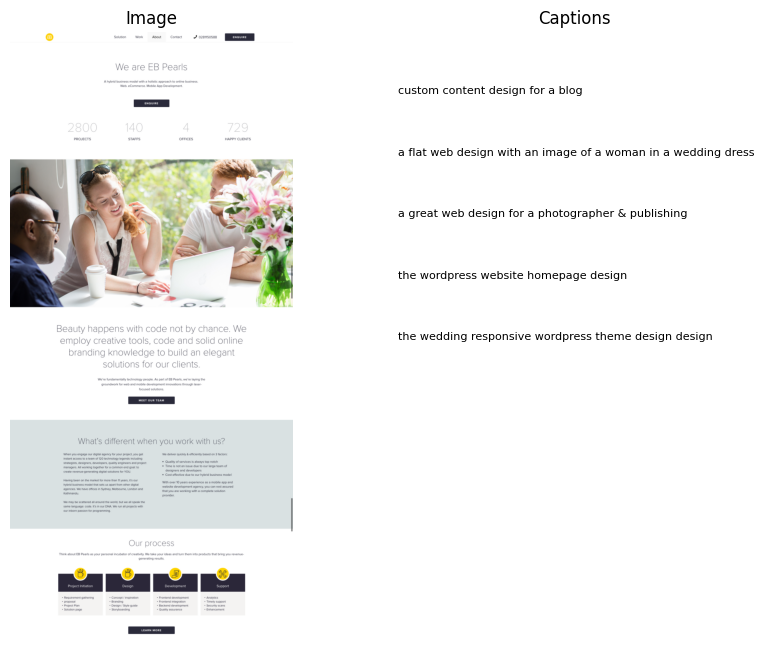

In [21]:
for image, captions in inference_dict.items(): 
    print(DATA_PATHS["inference_set_dir"] + image)
    plot_image_with_captions(DATA_PATHS["inference_set_dir"] + image, captions)